In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate

import scipy.ndimage
import re
# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 22})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [2]:
folder_experimental = rf"H:\phd stuff\tidy3d\output\Experimental Data\data_lsu_air_decaline"
transmission_experimental_air = []
transmission_experimental_decaline = []

for filename in os.listdir(folder_experimental):
    if Path(filename).suffix == ".txt":
        continue
    with open(os.path.join(folder_experimental,filename), 'rb') as file:
        content = file.read()
        
    # Decode the binary content to a string
    decoded_content = content.decode('utf-8')

    # Split the content into lines
    lines = decoded_content.split('\r\n')

    # Initialize an empty list to store the parsed values
    data = []

    # Loop through each line and split by the comma
    for line in lines:
        if line:  # Skip any empty lines
            value1, value2 = line.split(',')
            data.append([float(value1), float(value2)])  # Convert values to float

    if "decaline" in filename:
        transmission_experimental_decaline.append((data))
    else: 
        transmission_experimental_air.append(data)


transmission_experimental_air = np.array(transmission_experimental_air)
transmission_experimental_decaline = np.array(transmission_experimental_decaline)

    

In [3]:
sizes_exp = np.array([5.4,8.4,9.4,10.4,11.4,12.4,14.5,20.5])

In [8]:
##Load simulation data 
file_sim = ["20250627_far_field_eps_10p89_ff_20p73.h5","20250708_far_field_eps_10p89_ff_20p45_decaline_and_air.h5","20250715_far_field_eps_10p24_ff_20p45_air.h5","20250925_far_field_eps_10p24_ff_20p45_air.h5","20251006_far_field_eps_8p570256250000002_ff_21p72_air.h5"]
sim_data = {}
for sim in file_sim:
    with h5py.File(rf"./data/{sim}", 'r') as f:
        for item in f.keys():
            eps_value_match = re.search(r'eps_([+-]?\d+)p([+-]?\d+)', sim)
            eps_value = f"{eps_value_match.group(1)}.{eps_value_match.group(2)}"
            key =item+"_"+eps_value
            sim_data[key]={}
            sim_data[key]["far_field_power"] = f[item][:]
            
            sim_data[key]["n"]=np.sqrt(float(eps_value)) 
        

#get parameters to calculate integration in the cone 
file_sim_params = "./data/20250627_far_field_eps_10p89_ff_20p73_params.h5"

sim_data_params = {}

with h5py.File(file_sim_params, 'r') as f:
    for item in f.keys():
        sim_data_params[item] = f[item][:]


In [9]:
#Get parameters and reference 
r_proj=(sim_data_params["r_proj"])[0]
theta_proj=sim_data_params["theta_proj"]
phi_proj=sim_data_params["phi_proj"]
indices_15_30 = np.where(np.bool_(theta_proj*180/np.pi >=15) & np.bool_(theta_proj*180/np.pi <=30))[0]
r,theta,phi = r_proj,theta_proj[indices_15_30],phi_proj
lambdas = sim_data_params["lambdas"]
indices_degrees = np.where(np.bool_(theta_proj*180/np.pi >=15) & np.bool_(theta_proj*180/np.pi <=30))[0]

theta_slice = theta_proj[indices_degrees]
dtheta = np.diff(theta_slice)
dphi=np.diff(phi)[1]
theta_mid = 0.5 * (theta_slice[:-1] + theta_slice[1:]) 

dA = (r ** 2) * np.sin(theta_slice[1:]) * dtheta * dphi

transmission_15_30_degrees_0 = ((sim_data["reference.txt_10.89"]["far_field_power"][indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1)) #Reference
transmission_15_30_degrees_n_h_1p4_0 = ((sim_data["ref_decaline_n_h_1p96_10.89"]["far_field_power"][indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1)) #Reference



In [ ]:
import re
shrikage = 0.95
plt.rcParams.update({'font.size': 15})  
for i,item in enumerate(sim_data.keys()):
    if "ref" in item or "bg" in item:
        continue
    fig, ax = plt.subplots(1,figsize=(10, 5),dpi=100)
    transmission_normalized_15_degrees = ((sim_data[item]["far_field_power"][indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_15_30_degrees_0 
    sigma_tilted =14
    smoothed_transmission_15_degrees = scipy.ndimage.gaussian_filter1d(transmission_normalized_15_degrees, sigma_tilted)
    sigma_physical = np.diff(td.C_0/lambdas)[0] * sigma_tilted
    sigma_physical
    data_for_FS = [lambdas*shrikage]

    ####Get size 
    slab_size = 14.3*0.8*float(re.search(r'size_([+-]?\d+(?:\.\d+)?)', item).group(1))
    idx_eperiment = (np.abs(sizes_exp - slab_size)).argmin()-1
    print(rf"exp_size_{sizes_exp[idx_eperiment]}")
    print(item)
    ############
    
    ax.plot(shrikage*lambdas,smoothed_transmission_15_degrees,"*",label=rf"Convolution simulation")
    ax.plot(shrikage*lambdas,transmission_normalized_15_degrees,"o",label=rf"Simulation Cassegrain")
    data_for_FS.append(transmission_normalized_15_degrees)
    data_for_FS.append(smoothed_transmission_15_degrees)
    # np.savetxt(rf"sim_transmision_n_3p3_ff_20_s_0p95_size_{slab_size:.2f}_um.txt", np.transpose(data_for_FS) , fmt="%.18f", delimiter=" ", header="lambda transmission_cassegrain convolution", comments="")
    # np.savetxt(rf"experiment_transmision_n_3p3_ff_20_s_0p95_size_{slab_size:.2f}_um.txt", np.transpose([1e4/transmission_experimental_air[idx_eperiment,:,0],transmission_experimental_air[idx_eperiment,:,1]]) , fmt="%.18f", delimiter=" ", header="lambda transmission", comments="")

    ax.plot((1e4/transmission_experimental_air[idx_eperiment,:,0]),transmission_experimental_air[idx_eperiment,:,1],linewidth=4,label=rf"Experiment")
    ax.legend(loc=3)
    ax.grid(True, which="both")
    ax.set_yscale("log")
    ax.set_ylabel("Transmission")
    ax.set_title(rf"n_rod={sim_data[item]["n"]:.2f} $L_{{sim}}={slab_size:.2f}; L_{{exp}}= {sizes_exp[idx_eperiment]}$ ff_20% s={shrikage:.2f}")

    ax.set_xlim(np.min(lambdas*shrikage),np.max(lambdas*shrikage))
    ax.set_xlabel(rf'$\lambda (\mu m)$', fontsize=20)


    plt.tight_layout()
    plt.show()



In [10]:
sim_data.keys()

dict_keys(['ak4_1000_ends_rad_0.65_eps_ff_0.2073_size_0.47.txt_10.89', 'ak4_1000_ends_rad_0.65_eps_ff_0.2073_size_0.82.txt_10.89', 'ak4_1000_ends_rad_0.65_eps_ff_0.2073_size_1.txt_10.89', 'reference.txt_10.89', 'ak4_1000_ends_rad_0.645_eps_ff_0.2045_size_0.6993006993006993_10.89', 'ak4_1000_ends_rad_0.645_eps_ff_0.2045_size_0.6993006993006993_bg_1.96_10.89', 'ref_decaline_n_h_1p96_10.89', 'ak4_1000_ends_rad_0.645_eps_ff_0.2045_size_0.6993006993006993_10.24', 'ak4_1000_ends_rad_0.645_eps_ff_0.2045_size_0.8741258741258741_10.24', 'ak4_1000_ends_eps_ff_0.2172_size_0.6993006993006993_8.570256250000002'])

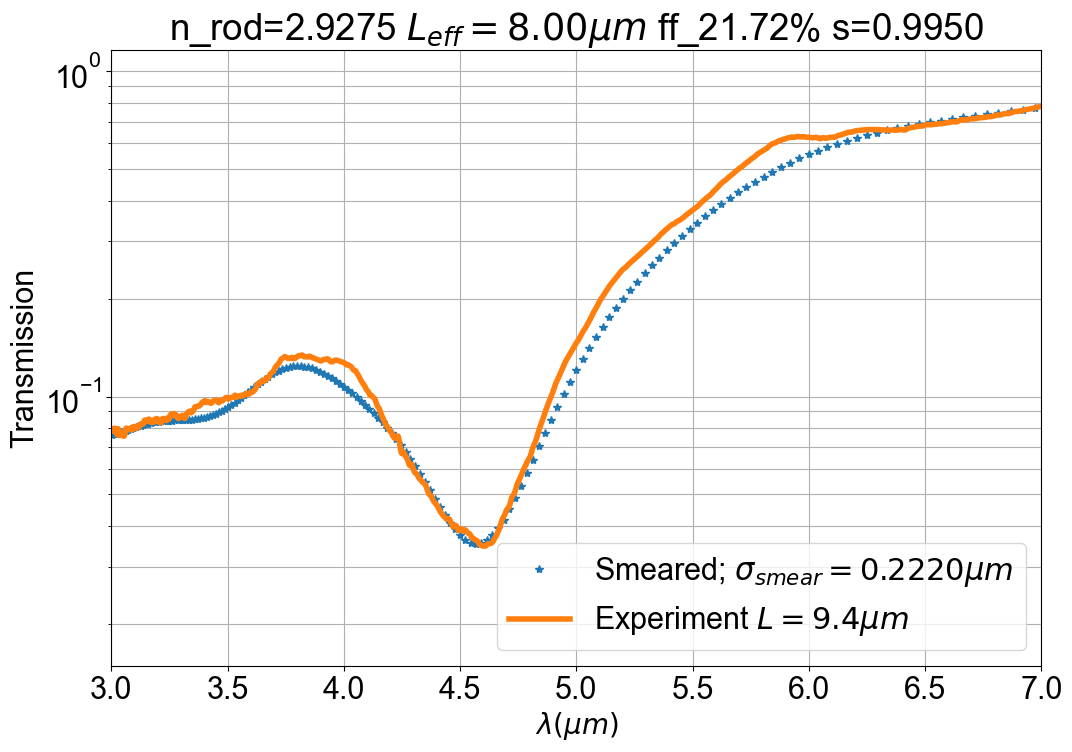

In [43]:
#Run adjusted thickness L=8
shrikage = 0.995
idx_exp=2
# sim_elements= ['ak4_1000_ends_rad_0.645_eps_ff_0.2045_size_0.6993006993006993_10.24', 'ak4_1000_ends_rad_0.645_eps_ff_0.2045_size_0.6993006993006993_bg_1.96_10.89']
sim_elements=["ak4_1000_ends_eps_ff_0.2172_size_0.6993006993006993_8.570256250000002"]
fig, ax = plt.subplots(figsize=(12,8))
transmission_normalized_15_degrees = ((sim_data[sim_elements[0]]["far_field_power"][indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_15_30_degrees_0 
# transmission_normalized_15_degrees_n_h_1p4 = ((sim_data[sim_elements[1]]["far_field_power"][indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_15_30_degrees_n_h_1p4_0 
sigma_tilted =9.1
smoothed_transmission_15_degrees = scipy.ndimage.gaussian_filter1d(transmission_normalized_15_degrees, sigma_tilted)
# smoothed_transmission_15_degrees_n_h_1p4 = scipy.ndimage.gaussian_filter1d(transmission_normalized_15_degrees_n_h_1p4, sigma_tilted)
sigma_physical = np.mean(np.diff(td.C_0/lambdas)) * sigma_tilted
# ax.plot(shrikage*lambdas,np.exp(np.log(transmission_normalized_15_degrees)),"o",label=rf" FDTD Unsmeared")
ax.plot(shrikage*lambdas,np.exp(np.log(smoothed_transmission_15_degrees)),"*",label=rf"Smeared; $\sigma_{{smear}}={(4.7**2*sigma_physical/td.C_0):.4f}\mu m$")
# ax.plot(shrikage*lambdas,np.exp(np.log(smoothed_transmission_15_degrees)*0.9),"*",label=rf"Smeared Rescaled Factor 0.9")
# ax.plot(0.9*lambdas,transmission_normalized_15_degrees_n_h_1p4,"o",label=rf"$n_h = 1.4$")
# ax.plot(0.9*lambdas,smoothed_transmission_15_degrees_n_h_1p4,"*",label=rf"Smeared $n_h = 1.4$")
ax.plot((1e4/transmission_experimental_air[idx_exp,:,0]),transmission_experimental_air[idx_exp,:,1],linewidth=4,label=rf"Experiment $L={sizes_exp[idx_exp]}\mu m$")
# ax.plot((1e4/transmission_experimental_decaline[2,:,0]),transmission_experimental_decaline[2,:,1],linewidth=4,label=rf"Experiment $n_h=1.4;L=9.4\mu m$")
ax.legend(loc=4)
ax.grid(True, which="both")
ax.set_yscale("log")
ax.set_ylabel("Transmission")
ax.set_title(rf"n_rod={sim_data[sim_elements[0]]["n"]:.4f} $L_{{eff}}={8:.2f} \mu m$ ff_21.72% s={shrikage:.4f}")
ax.set_xlim(3,7)
ax.set_xlabel(rf'$\lambda (\mu m)$', fontsize=20)
plt.show()




In [ ]:
#Run adjusted thickness L=8
shrikage = 0.954
idx_exp=4
sim_elements= ['ak4_1000_ends_rad_0.645_eps_ff_0.2045_size_0.8741258741258741_10.24']
fig, ax = plt.subplots(figsize=(12,8))
transmission_normalized_15_degrees = ((sim_data[sim_elements[0]]["far_field_power"][indices_degrees[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_15_30_degrees_0 
sigma_tilted =9.7
smoothed_transmission_15_degrees = scipy.ndimage.gaussian_filter1d(transmission_normalized_15_degrees, sigma_tilted)
smoothed_transmission_15_degrees_n_h_1p4 = scipy.ndimage.gaussian_filter1d(transmission_normalized_15_degrees_n_h_1p4, sigma_tilted)
sigma_physical = np.diff(td.C_0/lambdas)[0] * sigma_tilted
# ax.plot(shrikage*lambdas,np.exp(np.log(smoothed_transmission_15_degrees)),"*",label=rf"Smeared")
ax.plot(shrikage*lambdas,np.exp(np.log(smoothed_transmission_15_degrees)*0.92),"*",label=rf"Smeared Rescaled Factor 0.92")
ax.plot((1e4/transmission_experimental_air[idx_exp,:,0]),transmission_experimental_air[idx_exp,:,1],linewidth=4,label=rf"Experiment $L={sizes_exp[idx_exp]}\mu m$")
ax.legend(loc=4)
ax.grid(True, which="both")
ax.set_yscale("log")
ax.set_ylabel("Transmission")
ax.set_title(rf"n_rod={sim_data[sim_elements[0]]["n"]:.2f} $L_{{eff}}={10:.2f} \mu m$ ff_20.45% s={shrikage:.2f}")
ax.set_xlim(3,7)
ax.set_xlabel(rf'$\lambda (\mu m)$', fontsize=20)
plt.show()



In [ ]:

# data_for_FS_n_h_1 = [lambdas*shrikage]
# data_for_FS_n_h_1.append(transmission_normalized_15_degrees)
# data_for_FS_n_h_1.append(smoothed_transmission_15_degrees)
# data_for_FS_n_h_1p4 = [lambdas*shrikage]
# data_for_FS_n_h_1p4.append(transmission_normalized_15_degrees_n_h_1p4)
# data_for_FS_n_h_1p4.append(smoothed_transmission_15_degrees_n_h_1p4)

In [ ]:
# np.savetxt(rf"sim_n_h_1_n_3p2_ff_20_s_0p98_size_{8:.2f}_um.txt", np.transpose(data_for_FS_n_h_1) , fmt="%.18f", delimiter=" ", header="lambda transmission_cassegrain convolution", comments="")
# np.savetxt(rf"sim_n_h_1p4_n_3p3_ff_20_s_0p95_size_{8:.2f}_um.txt", np.transpose(data_for_FS_n_h_1p4) , fmt="%.18f", delimiter=" ", header="lambda transmission_cassegrain convolution", comments="")
# np.savetxt(rf"experiment_n_h_1_n_3p3_ff_20_s_0p95_size_{9.4:.2f}_um.txt", np.transpose([1e4/transmission_experimental_air[2,:,0],transmission_experimental_air[2,:,1]]) , fmt="%.18f", delimiter=" ", header="lambda transmission", comments="")
# np.savetxt(rf"experiment_n_h_1p4_n_3p3_ff_20_s_0p95_size_{9.4:.2f}_um.txt", np.transpose([1e4/transmission_experimental_decaline[2,:,0],transmission_experimental_decaline[2,:,1]]) , fmt="%.18f", delimiter=" ", header="lambda transmission", comments="")
